In [6]:
import os
import glob
import shutil
import numpy as np 
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
from scipy import signal
import random 
from tensorflow import keras 
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import tensorflow as tf
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import Reshape,CuDNNLSTM,LeakyReLU,ZeroPadding1D,Conv1D,BatchNormalization,Activation,MaxPooling1D,Dropout,Dense,Flatten,Bidirectional,LSTM,GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping,ReduceLROnPlateau
import itertools

from model import *

In [128]:
prep_path = '/home/ubuntu/Dataset/prep_path_pulse1/'
label_csv = '/home/ubuntu/Dataset/현황_간소화.xlsx'
model_path = '/home/ubuntu/Dataset/model/'
seed = 7

total_len = 194

def load_label():
    label_filename = label_csv
    label_df = pd.read_excel(label_filename,header=2).drop([0]) # remove first line(figure)
    label_df = label_df[['실험NO.','중증도\n5단계']]
    label_df.columns=['subjectnb','label']
    label_df.replace({'label':{'Normal':0,'Presymptomatic AD':0,'Prodroaml AD':1,'AD Dementia 초기 ':3,'AD Dementia 초기':3,'AD Dementia 중기 ':4,'AD Dementia중기 ':4,'MCI unlikely due to AD':5,'PET or CSF (x)':6}},inplace=True)
    label_df.set_index(['subjectnb'],inplace=True)
    
    return dict(label_df.label)


label_dict = load_label()

class Subject():
    def __init__(self,snum,label_dict):
        if type(snum) is int:
            self.snum = 'S{:03}'.format(snum)
        elif type(snum) is str:
            self.snum = snum
        self.path = prep_path+self.snum
        self.data_dict = dict()
        
        for i in range(1,5):
            self.data_dict['E{}'.format(i)] = os.listdir(self.path+'/E{}'.format(i))
            self.data_dict['E{}'.format(i)].sort()
        
        self.severity = label_dict[self.snum]
    def load_data(self,filename):
        data = np.load(filename)
        return data
    
    def get_snum(self):
        return self.snum
    def get_severity(self):
        return self.severity
    
    def get_filenames(self,enum):
        return self.data_dict['E{}'.format(enum)]
    
    def get_filenames_path(self,enum):
        res = []
        file_path = self.path+'/E{}'.format(enum)
        for filename in self.data_dict['E{}'.format(enum)] :
            res.append(file_path+'/'+filename)
        return res
    
    def get_data(self,enum):
        res = []
        filenames = self.get_filenames_path(enum)
        
        for filename in filenames:
            res.append(self.load_data(filename))
        
        return res
    
    def get_len(self):
        res = []
        for i in self.data_dict:
            res.append(len(self.data_dict[i]))
        
        return res
    
    def print_info(self):
        print('{} = severity : {}, '.format(self.snum,self.severity),end='')
        for i,num in enumerate(self.get_len()):
            print('E{} len: {} '.format(i+1,num),end = ',\t')
        print()

S_cnt =  [[] for x in range(7) ]

E_cnt = np.zeros(4,dtype=int)

for i in range(1,total_len+1):
    tmp = Subject(i,label_dict)
    tmp.print_info()
    S_cnt[tmp.get_severity()].append(tmp.get_snum()) 
    E_cnt += tmp.get_len()
    
    
    
    
    
print()
print('S total : ',)
for i,s in enumerate(S_cnt):
    print('E{} : {} '.format(i+1,len(s)),end = ',\t')
print()   
print('E total : ')
for i,e in enumerate(E_cnt):
    print('E{} : {} '.format(i+1,e),end = ',\t')

def subject_split(S_cnt,using_num=[0,1],seed = random.randint(1,100),print_list=False):
    train,val,test = [],[],[]
    
    for i in using_num:
        train_list,remain_list = train_test_split(S_cnt[i],test_size=0.3, random_state=seed)
        val_list,test_list = train_test_split(remain_list,test_size=0.7, random_state=seed)
        print('label {} split result = train : {} , val : {} , test : {} : '.format(i,len(train_list),len(val_list),len(test_list)))
        train.extend(train_list)
        val.extend(val_list)
        test.extend(test_list)
    
    train.sort()
    val.sort()
    test.sort()
    print('total split result = train : {} , val : {} , test : {}'.format(len(train),len(val),len(test)))
    
    if print_list:
        print('\ntrain_list\n', train)
        print('\nval_list\n', val)
        print('\ntest_list\n', test)
        
    return train,val,test





def preprocessing(train_list,val_list,test_list,e_num=1,is_scale=False,resampling_len = 32*32):
    X_train,y_train = [],[]
    X_val,y_val = [],[]
    X_test,y_test = [],[]
    
    
    label_dict = load_label()
    
    print('train_list data load')
    for i in train_list:
#         print(i)
        
        tmp = Subject(i,label_dict)
        label = tmp.get_severity()
        data = tmp.get_data(e_num)
        
        for j in data:
            tmp_x = np.zeros((32,32, 63)).astype(np.float32)
            for k in range(63):
                resample = signal.resample(j[:,k],resampling_len)
                
                if is_scale:
                    
                    scaler = MinMaxScaler(feature_range=(-1,1))
                    resample = scaler.fit_transform(resample.reshape(-1,1))
                
                tmp_x[:,:,k] = np.reshape(resample,(32,32))
                
            
            
#             plt.figure(figsize=(15,15))
#             for k in range(63):
#                 plt.subplot(7,9,k+1)
#                 plt.plot(tmp_x[:,k])
#             return
            X_train.append(tmp_x)
            y_train.append(label)
        
    print('val_list data load')
    print(val_list)
    for i in val_list:
#         print(i)
        
        tmp = Subject(i,label_dict)
        label = tmp.get_severity()
        data = tmp.get_data(e_num)
        for j in data:
            tmp_x = np.zeros((32,32, 63)).astype(np.float32)
            for k in range(63):
#                 tmp_x[:,k] = signal.resample(j[:,k],resampling_len)
                resample = signal.resample(j[:,k],resampling_len)
    
                if is_scale:
                    
                    scaler = MinMaxScaler(feature_range=(-1,1))
                    resample = scaler.fit_transform(resample.reshape(-1,1))
    
                tmp_x[:,:,k] = np.reshape(resample,(32,32))
                
            
                
                
            
            X_val.append(tmp_x)
            y_val.append(label)
            
    print('test_list data load')
    print(test_list)

    for i in test_list:
#         print(i)
        
        tmp = Subject(i,label_dict)
        label = tmp.get_severity()
        data = tmp.get_data(e_num)
        for j in data:
            tmp_x = np.zeros((32,32, 63)).astype(np.float32)
            for k in range(63):
                resample = signal.resample(j[:,k],resampling_len)
                plt.plot(resample)
                return
                if is_scale:
                    
                    scaler = MinMaxScaler(feature_range=(-1,1))
                    resample = scaler.fit_transform(resample.reshape(-1,1))
                
                tmp_x[:,:,k] = np.reshape(resample,(32,32))
#                 tmp_x[:,k] = signal.resample(j[:,k],resampling_len)
                
#             plt.figure(figsize=(15,15))
#             for k in range(63):
#                 plt.subplot(7,9,k+1)
#                 plt.plot(tmp_x[:,k])
#             return
            X_test.append(tmp_x)
            y_test.append(label)
            
            
    enc = OneHotEncoder()
    
    X_train = np.array(X_train)
    
    y_train = np.reshape(y_train,(-1,1))
    y_train = enc.fit_transform(y_train).toarray()
    
    X_val = np.array(X_val)
    
    y_val = np.reshape(y_val,(-1,1))
    y_val = enc.fit_transform(y_val).toarray()
    
    X_test = np.array(X_test)
    
    y_test = np.reshape(y_test,(-1,1))
    y_test = enc.fit_transform(y_test).toarray()
    
    return X_train,y_train,X_val,y_val,X_test,y_test

S001 = severity : 0, E1 len: 4 ,	E2 len: 4 ,	E3 len: 8 ,	E4 len: 5 ,	
S002 = severity : 0, E1 len: 2 ,	E2 len: 4 ,	E3 len: 8 ,	E4 len: 0 ,	
S003 = severity : 0, E1 len: 2 ,	E2 len: 2 ,	E3 len: 6 ,	E4 len: 0 ,	
S004 = severity : 0, E1 len: 2 ,	E2 len: 4 ,	E3 len: 14 ,	E4 len: 0 ,	
S005 = severity : 0, E1 len: 2 ,	E2 len: 2 ,	E3 len: 9 ,	E4 len: 6 ,	
S006 = severity : 3, E1 len: 4 ,	E2 len: 2 ,	E3 len: 5 ,	E4 len: 6 ,	
S007 = severity : 1, E1 len: 2 ,	E2 len: 6 ,	E3 len: 6 ,	E4 len: 11 ,	
S008 = severity : 0, E1 len: 2 ,	E2 len: 2 ,	E3 len: 5 ,	E4 len: 4 ,	
S009 = severity : 0, E1 len: 2 ,	E2 len: 2 ,	E3 len: 7 ,	E4 len: 5 ,	
S010 = severity : 0, E1 len: 3 ,	E2 len: 3 ,	E3 len: 6 ,	E4 len: 6 ,	
S011 = severity : 0, E1 len: 2 ,	E2 len: 2 ,	E3 len: 5 ,	E4 len: 4 ,	
S012 = severity : 5, E1 len: 2 ,	E2 len: 2 ,	E3 len: 6 ,	E4 len: 5 ,	
S013 = severity : 5, E1 len: 2 ,	E2 len: 2 ,	E3 len: 8 ,	E4 len: 5 ,	
S014 = severity : 5, E1 len: 4 ,	E2 len: 4 ,	E3 len: 15 ,	E4 len: 11 ,	
S015 = severity 

label 0 split result = train : 66 , val : 8 , test : 21 : 
label 1 split result = train : 48 , val : 6 , test : 15 : 
total split result = train : 114 , val : 14 , test : 36

train_list
 ['S001', 'S002', 'S004', 'S005', 'S007', 'S009', 'S010', 'S011', 'S017', 'S018', 'S023', 'S024', 'S027', 'S031', 'S032', 'S033', 'S034', 'S035', 'S037', 'S038', 'S039', 'S040', 'S041', 'S042', 'S043', 'S046', 'S048', 'S049', 'S050', 'S053', 'S054', 'S055', 'S057', 'S058', 'S061', 'S062', 'S065', 'S069', 'S075', 'S076', 'S077', 'S078', 'S079', 'S080', 'S081', 'S085', 'S086', 'S087', 'S088', 'S089', 'S090', 'S091', 'S092', 'S093', 'S096', 'S097', 'S099', 'S100', 'S101', 'S102', 'S105', 'S108', 'S110', 'S112', 'S116', 'S117', 'S118', 'S120', 'S121', 'S122', 'S123', 'S125', 'S126', 'S128', 'S129', 'S130', 'S131', 'S132', 'S133', 'S134', 'S135', 'S136', 'S137', 'S139', 'S140', 'S141', 'S143', 'S145', 'S146', 'S147', 'S148', 'S150', 'S151', 'S153', 'S155', 'S157', 'S158', 'S159', 'S160', 'S162', 'S164', 'S16

TypeError: 'NoneType' object is not iterable

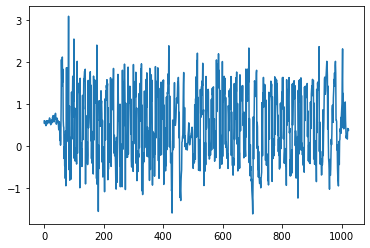

In [129]:

train_list,val_list,test_list = subject_split(S_cnt = S_cnt,using_num=[0,1] ,seed = 7,print_list=True)
X_train,y_train,X_val,y_val,X_test,y_test = preprocessing(train_list,val_list,test_list,is_scale=True,e_num=3)

In [102]:
def get_model1(input_shape,nb_classes):
    n_feature_maps = 64

    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    
    
    return model

In [103]:
def get_model2(input_shape,nb_classes):
    n_feature_maps = 128
    input_layer = keras.layers.Input(shape=(input_shape))
    
    conv_x = keras.layers.BatchNormalization()(input_layer)
    conv_x = keras.layers.Conv1D(n_feature_maps, 8, 1, padding='same')(conv_x)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv1D(n_feature_maps, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv1D(n_feature_maps, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv1D(n_feature_maps, 1, 1,padding='same')(input_layer)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(input_layer)
    print ('Merging skip connection')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv1D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv1D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv1D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv1D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv1D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv1D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv1D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv1D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    full = keras.layers.GlobalAveragePooling1D()(y)
    out = keras.layers.Dense(nb_classes, activation='softmax')(full)
    
    model = keras.models.Model(inputs=input_layer, outputs=out)
    
    return model

In [104]:
def get_model3(input_shape,nb_classes):

    input_layer = keras.layers.Input(input_shape)
    
    x = LSTM(50,return_sequences=True)(input_layer)
    x = Dropout(0.5)(x)

    x = LSTM(224)(x)
    x = Dropout(0.5)(x)
    
    # FINAL

    output_layer = keras.layers.Dense(nb_classes,activation='softmax')(x)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [105]:
def get_model4(input_shape,nb_classes):
    
    
    # RNN Model
    rnn = Sequential()
    rnn.add(CuDNNLSTM(3,input_shape=input_shape, return_sequences=True, kernel_initializer='TruncatedNormal'))
    rnn.add(BatchNormalization())
    rnn.add(LeakyReLU())
    rnn.add(Dropout(0.622))
    
    for _ in range(0):
        rnn.add(CuDNNLSTM(32, kernel_initializer='TruncatedNormal', return_sequences=True))
        rnn.add(BatchNormalization())
        rnn.add(LeakyReLU())
        rnn.add(Dropout(0.612))   
    
    rnn.add(CuDNNLSTM(4, kernel_initializer='TruncatedNormal', return_sequences=False))
    rnn.add(BatchNormalization())
    rnn.add(LeakyReLU())
    rnn.add(Dropout(0.281))
    
    # DNN Model
    
    dnn = rnn
    
    for _ in range(4):
        dnn.add(Dense(128, kernel_initializer='TruncatedNormal'))
        dnn.add(BatchNormalization())
        dnn.add(LeakyReLU())
        dnn.add(Dropout(0.006))
                 
    for _ in range(4):
        dnn.add(Dense(16, kernel_initializer='TruncatedNormal'))
        dnn.add(BatchNormalization())
        dnn.add(LeakyReLU())
        dnn.add(Dropout(0.08))
    
    for _ in range(4):
        dnn.add(Dense(256, kernel_initializer='TruncatedNormal'))
        dnn.add(BatchNormalization())
        dnn.add(LeakyReLU())
        dnn.add(Dropout(0.171))
  
    dnn.add(Dense(512, kernel_initializer='TruncatedNormal'))
    dnn.add(BatchNormalization())
    dnn.add(LeakyReLU())
    dnn.add(Dropout(0.257))
    
    dnn.add(Dense(nb_classes))
    dnn.add(Activation('softmax'))
    
    
    return dnn

In [106]:
def get_model5(input_shape,nb_classes):
    seq_length = 256
    kernel_size = 3
    activation = "relu"
    padding = "valid"
    inp = keras.layers.Input(shape=(input_shape))
    # CONV1
    x = Conv1D(filters=128,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(inp)
    x = MaxPooling1D(2)(x)

    # CONV2
    x = Conv1D(filters=128,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # CONV3
    x = Conv1D(filters=128,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # CONV4
    x = Conv1D(filters=128,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # Residual block
#     inp_res = Fla((12, 64))(inp)
#     x = Concatenate(axis=-1)([x, inp_res])

    # Flatten, FC1, FC2, Softmax
    x = Flatten()(x)
    x = Dense(150, activation=activation)(x)
    x = Dense(100, activation=activation)(x)
    x = Dense(2, activation="softmax")(x)

    return Model(inputs=inp, outputs=x)

In [107]:
def conv2d(input_shape,nb_classes):
    n_feature_maps = 192

    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1

    conv_x = keras.layers.Conv2D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv2D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv2D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv2D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling2D()(output_block_3)

    output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    
    
    return model

In [108]:
def res3d(inputs, weight_decay):
    # Res3D Block 1
    conv3d_1 = keras.layers.Conv1D(64, 3, strides=(1,2,2), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False,
                    name='Conv1D_1')(inputs)
    conv3d_1 = keras.layers.BatchNormalization(name='BatchNorm_1_0')(conv3d_1)
    conv3d_1 = keras.layers.Activation('relu', name='ReLU_1')(conv3d_1)

    # Res3D Block 2
    conv3d_2a_1 = keras.layers.Conv1D(64, 1, strides=(1,1,1), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_2a_1')(conv3d_1)
    conv3d_2a_1 = keras.layers.BatchNormalization(name='BatchNorm_2a_1')(conv3d_2a_1)
    conv3d_2a_a = keras.layers.Conv1D(64, 3, strides=(1,1,1), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_2a_a')(conv3d_1)
    conv3d_2a_a = keras.layers.BatchNormalization(name='BatchNorm_2a_a')(conv3d_2a_a)
    conv3d_2a_a = keras.layers.Activation('relu', name='ReLU_2a_a')(conv3d_2a_a)
    conv3d_2a_b = keras.layers.Conv1D(64, (3,3,3), strides=(1,1,1), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_2a_b')(conv3d_2a_a)
    conv3d_2a_b = keras.layers.BatchNormalization(name='BatchNorm_2a_b')(conv3d_2a_b)
    conv3d_2a = keras.layers.Add(name='Add_2a')([conv3d_2a_1, conv3d_2a_b])
    conv3d_2a = keras.layers.Activation('relu', name='ReLU_2a')(conv3d_2a)

    conv3d_2b_a = keras.layers.Conv1D(64, (3,3,3), strides=(1,1,1), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_2b_a')(conv3d_2a)
    conv3d_2b_a = keras.layers.BatchNormalization(name='BatchNorm_2b_a')(conv3d_2b_a)
    conv3d_2b_a = keras.layers.Activation('relu', name='ReLU_2b_a')(conv3d_2b_a)
    conv3d_2b_b = keras.layers.Conv1D(64, (3,3,3), strides=(1,1,1), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_2b_b')(conv3d_2b_a)
    conv3d_2b_b = keras.layers.BatchNormalization(name='BatchNorm_2b_b')(conv3d_2b_b)
    conv3d_2b = keras.layers.Add(name='Add_2b')([conv3d_2a, conv3d_2b_b])
    conv3d_2b = keras.layers.Activation('relu', name='ReLU_2b')(conv3d_2b)

    # Res3D Block 3
    conv3d_3a_1 = keras.layers.Conv1D(128, (1,1,1), strides=(2,2,2), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_3a_1')(conv3d_2b)
    conv3d_3a_1 = keras.layers.BatchNormalization(name='BatchNorm_3a_1')(conv3d_3a_1)
    conv3d_3a_a = keras.layers.Conv1D(128, (3,3,3), strides=(2,2,2), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_3a_a')(conv3d_2b)
    conv3d_3a_a = keras.layers.BatchNormalization(name='BatchNorm_3a_a')(conv3d_3a_a)
    conv3d_3a_a = keras.layers.Activation('relu', name='ReLU_3a_a')(conv3d_3a_a)
    conv3d_3a_b = keras.layers.Conv1D(128, (3,3,3), strides=(1,1,1), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_3a_b')(conv3d_3a_a)
    conv3d_3a_b = keras.layers.BatchNormalization(name='BatchNorm_3a_b')(conv3d_3a_b)
    conv3d_3a = keras.layers.Add(name='Add_3a')([conv3d_3a_1, conv3d_3a_b])
    conv3d_3a = keras.layers.Activation('relu', name='ReLU_3a')(conv3d_3a)

    conv3d_3b_a = keras.layers.Conv1D(128, (3,3,3), strides=(1,1,1), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_3b_a')(conv3d_3a)
    conv3d_3b_a = keras.layers.BatchNormalization(name='BatchNorm_3b_a')(conv3d_3b_a)
    conv3d_3b_a = keras.layers.Activation('relu', name='ReLU_3b_a')(conv3d_3b_a)
    conv3d_3b_b = keras.layers.Conv1D(128, (3,3,3), strides=(1,1,1), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_3b_b')(conv3d_3b_a)
    conv3d_3b_b = keras.layers.BatchNormalization(name='BatchNorm_3b_b')(conv3d_3b_b)
    conv3d_3b = keras.layers.Add(name='Add_3b')([conv3d_3a, conv3d_3b_b])
    conv3d_3b = keras.layers.Activation('relu', name='ReLU_3b')(conv3d_3b)

    # Res3D Block 4
    conv3d_4a_1 = keras.layers.Conv1D(256, (1,1,1), strides=(1,1,1), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_4a_1')(conv3d_3b)
    conv3d_4a_1 = keras.layers.BatchNormalization(name='BatchNorm_4a_1')(conv3d_4a_1)
    conv3d_4a_a = keras.layers.Conv1D(256, (3,3,3), strides=(1,1,1), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_4a_a')(conv3d_3b)
    conv3d_4a_a = keras.layers.BatchNormalization(name='BatchNorm_4a_a')(conv3d_4a_a)
    conv3d_4a_a = keras.layers.Activation('relu', name='ReLU_4a_a')(conv3d_4a_a)
    conv3d_4a_b = keras.layers.Conv1D(256, (3,3,3), strides=(1,1,1), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_4a_b')(conv3d_4a_a)
    conv3d_4a_b = keras.layers.BatchNormalization(name='BatchNorm_4a_b')(conv3d_4a_b)
    conv3d_4a = keras.layers.Add(name='Add_4a')([conv3d_4a_1, conv3d_4a_b])
    conv3d_4a = keras.layers.Activation('relu', name='ReLU_4a')(conv3d_4a)

    conv3d_4b_a = keras.layers.Conv1D(256, (3,3,3), strides=(1,1,1), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_4b_a')(conv3d_4a)
    conv3d_4b_a = keras.layers.BatchNormalization(name='BatchNorm_4b_a')(conv3d_4b_a)
    conv3d_4b_a = keras.layers.Activation('relu', name='ReLU_4b_a')(conv3d_4b_a)
    conv3d_4b_b = keras.layers.Conv1D(256, (3,3,3), strides=(1,1,1), padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv1D_4b_b')(conv3d_4b_a)
    conv3d_4b_b = keras.layers.BatchNormalization(name='BatchNorm_4b_b')(conv3d_4b_b)
    conv3d_4b = keras.layers.Add(name='Add_4b')([conv3d_4a, conv3d_4b_b])
    conv3d_4b = keras.layers.Activation('relu', name='ReLU_4b')(conv3d_4b)

    return conv3d_4b

In [109]:
get_model5((224,3),2).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 224, 3)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 222, 128)          1280      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 111, 128)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 109, 128)          49280     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 54, 128)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 52, 128)           49280     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 26, 128)           0         
__________

In [90]:
def cnn_model(input_shape, drop_rate=0.5, nb_classes=2):
    model=Sequential()
    
    # Layer 1
    model.add(Conv1D (kernel_size=3, filters=256, strides=1, padding='same',
                      kernel_initializer='he_uniform', input_shape=input_shape))                  
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Layer 2
    model.add(Conv1D(kernel_size=3, filters=256, strides=1, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Layer 3
    model.add(Conv1D (kernel_size=3, filters=256, strides=2, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
    
    # Layer 3
    model.add(Conv1D (kernel_size=3, filters=256, strides=2, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
    
    # Layer 3
    model.add(Conv1D (kernel_size=3, filters=256, strides=2, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
    
    # Layer 3
    model.add(Conv1D (kernel_size=3, filters=256, strides=2, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    

    

    # Layer 11
    model.add(Dropout(drop_rate))
    model.add(GlobalAveragePooling1D())

    # Layer 12
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    return model

In [115]:
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D
def cnn_model(input_shape, drop_rate=0.5, nb_classes=2):
    model=Sequential()
    
    # Layer 1
    model.add(Conv2D (kernel_size=3, filters=256, strides=1, padding='same',
                      kernel_initializer='he_uniform', input_shape=input_shape))                  
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Layer 2
    model.add(Conv2D(kernel_size=3, filters=256, strides=1, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Layer 3
    model.add(Conv2D (kernel_size=3, filters=256, strides=2, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=2, strides=2))
    
    # Layer 3
    model.add(Conv2D (kernel_size=3, filters=256, strides=2, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=2, strides=2))
    
    # Layer 3
    model.add(Conv2D (kernel_size=3, filters=256, strides=2, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=2, strides=2))
    
    # Layer 3
    model.add(Conv2D (kernel_size=3, filters=256, strides=2, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    

    

    # Layer 11
    model.add(Dropout(drop_rate))
    model.add(GlobalAveragePooling2D())

    # Layer 12
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    return model

In [116]:
# # test result visulization
# def test(model,weight_path,X_test,y_test):
#     model = model
#     model.load_weights(weigth_file)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()    
    

In [123]:
def one_shot(e_num = 3):
    batch_size = 16
    epochs = 100
    input_shape = (224,63)
    output_size = 2
    
    
    
    now = datetime.now()
    nowDate = now.strftime('%d_%H_%M_%S')
    model_name = 'my_model'+ nowDate
    
    
#     model = get_model5(input_shape = (224,63),nb_classes = 2)
    model = cnn_model(input_shape = (32,32,63),nb_classes = 2)
#     model = MyModel(training=True)
#     model = conv2d(input_shape = (16,16,63),nb_classes = 2)
    
#     model = cnn_model(input_shape=input_shape, output_size=output_size)
    model.summary()
    
    model = multi_gpu_model(model,gpus=2)
    model.summary()
    model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='sgd')
    
    # Validation 점수가 가장 좋은 모델만 저장합니다.
    checkpoint_path = os.path.join(model_path, model_name)
    os.makedirs(checkpoint_path, exist_ok=True)
    model_file_path = os.path.join(checkpoint_path, 'Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5')
    checkpoint = ModelCheckpoint(filepath=model_file_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 10회 간 Validation 점수가 좋아지지 않으면 중지합니다.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
    
    train_list,val_list,test_list = subject_split(S_cnt = S_cnt,using_num=[0,1],print_list=True)
    X_train,y_train,X_val,y_val,X_test,y_test = preprocessing(train_list,val_list,test_list,is_scale=True,e_num=e_num)
    
    
    print('train len : ', np.shape(X_train),np.shape(y_train))
    print('val len : ', np.shape(X_val),np.shape(y_val))
    print('test len : ', np.shape(X_test),np.shape(y_test))
    history = model.fit(
    X_train, y_train, validation_data=(X_val,y_val),
    epochs=epochs, batch_size=batch_size,  shuffle=True,
    callbacks=[checkpoint, early_stopping])
#     X_train, X_train, validation_data=(X_val,X_val),
#     epochs=epochs, batch_size=batch_size,  shuffle=True,
#     callbacks=[checkpoint, early_stopping,reduce_lr])    
    
        
    plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
    plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
    plt.legend()
    plt.xlim(left=0)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
        
    checkpoint_path = os.path.join(model_path, model_name)
    print(checkpoint_path)
    weigth_files = glob.glob('{}/*.hdf5'.format(checkpoint_path))
    weigth_files.sort()
    weigth_file = weigth_files[-1]
    print(weigth_files)
    print(weigth_file)
    model.load_weights(weigth_file)
    
    
    y_pred = model.predict(X_test)
#     print(y_pred)
#     print(y_test)
    y_true,y_pred = np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1)
    test_acc = accuracy_score(y_true,y_pred)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cnf_matrix,['N','MCI'],title='model : {} , test_acc : {}'.format(model_name,test_acc))
    
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_213 (Conv2D)          (None, 32, 32, 256)       145408    
_________________________________________________________________
batch_normalization_229 (Bat (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_169 (Activation)  (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_214 (Conv2D)          (None, 32, 32, 256)       590080    
_________________________________________________________________
batch_normalization_230 (Bat (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_170 (Activation)  (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_215 (Conv2D)          (None, 16, 16, 256)       590080    
__________

Epoch 6/100
304/323 [===========================>..] - ETA: 0s - loss: 0.1467
Epoch 00006: val_loss did not improve from 0.71014
323/323 [==============================] - 1s 2ms/step - loss: 0.1493 - val_loss: 0.8643
Epoch 7/100
320/323 [============================>.] - ETA: 0s - loss: 0.1336
Epoch 00007: val_loss did not improve from 0.71014
323/323 [==============================] - 1s 2ms/step - loss: 0.1339 - val_loss: 0.8550
Epoch 8/100
304/323 [===========================>..] - ETA: 0s - loss: 0.0968
Epoch 00008: val_loss did not improve from 0.71014
323/323 [==============================] - 1s 2ms/step - loss: 0.1089 - val_loss: 0.8605
Epoch 9/100
288/323 [=========================>....] - ETA: 0s - loss: 0.0841
Epoch 00009: val_loss did not improve from 0.71014
323/323 [==============================] - 1s 2ms/step - loss: 0.0885 - val_loss: 0.8770
Epoch 10/100
304/323 [===========================>..] - ETA: 0s - loss: 0.0954
Epoch 00010: val_loss did not improve from 0.7101

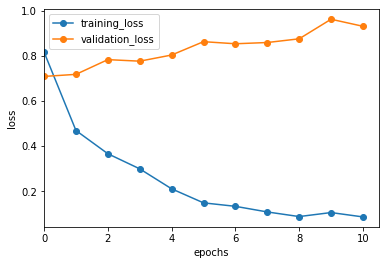

/home/ubuntu/Dataset/model/my_model09_16_27_50
['/home/ubuntu/Dataset/model/my_model09_16_27_50/Epoch_001_Val_0.710.hdf5']
/home/ubuntu/Dataset/model/my_model09_16_27_50/Epoch_001_Val_0.710.hdf5


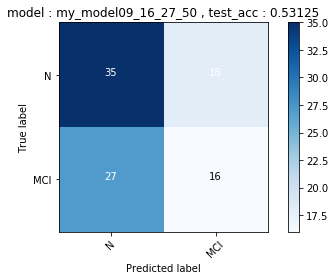

In [124]:
one_shot(e_num=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_219 (Conv2D)          (None, 32, 32, 256)       145408    
_________________________________________________________________
batch_normalization_235 (Bat (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_176 (Activation)  (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 32, 32, 256)       590080    
_________________________________________________________________
batch_normalization_236 (Bat (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_177 (Activation)  (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 16, 16, 256)       590080    
__________

Epoch 6/100
288/322 [=========================>....] - ETA: 0s - loss: 0.1431
Epoch 00006: val_loss did not improve from 0.70764
322/322 [==============================] - 1s 2ms/step - loss: 0.1554 - val_loss: 0.8260
Epoch 7/100
320/322 [============================>.] - ETA: 0s - loss: 0.1440
Epoch 00007: val_loss did not improve from 0.70764
322/322 [==============================] - 1s 2ms/step - loss: 0.1459 - val_loss: 0.8286
Epoch 8/100
320/322 [============================>.] - ETA: 0s - loss: 0.0974
Epoch 00008: val_loss did not improve from 0.70764
322/322 [==============================] - 1s 2ms/step - loss: 0.1010 - val_loss: 0.8222
Epoch 9/100
288/322 [=========================>....] - ETA: 0s - loss: 0.0857
Epoch 00009: val_loss did not improve from 0.70764
322/322 [==============================] - 1s 2ms/step - loss: 0.0849 - val_loss: 0.8846
Epoch 10/100
288/322 [=========================>....] - ETA: 0s - loss: 0.1416
Epoch 00010: val_loss did not improve from 0.7076

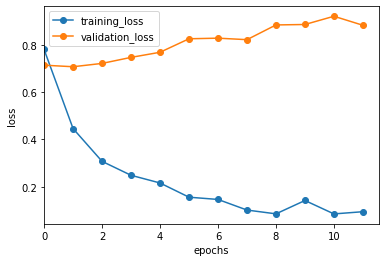

/home/ubuntu/Dataset/model/my_model09_16_29_58
['/home/ubuntu/Dataset/model/my_model09_16_29_58/Epoch_001_Val_0.714.hdf5', '/home/ubuntu/Dataset/model/my_model09_16_29_58/Epoch_002_Val_0.708.hdf5']
/home/ubuntu/Dataset/model/my_model09_16_29_58/Epoch_002_Val_0.708.hdf5


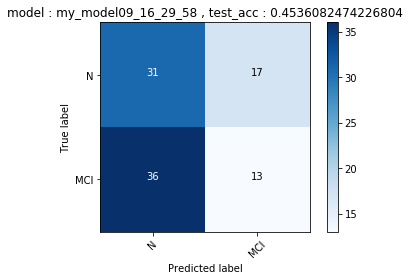

In [125]:
one_shot(e_num=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_225 (Conv2D)          (None, 32, 32, 256)       145408    
_________________________________________________________________
batch_normalization_241 (Bat (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_183 (Activation)  (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 32, 32, 256)       590080    
_________________________________________________________________
batch_normalization_242 (Bat (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_184 (Activation)  (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_227 (Conv2D)          (None, 16, 16, 256)       590080    
__________

Epoch 6/100
848/868 [============================>.] - ETA: 0s - loss: 0.1399
Epoch 00006: val_loss did not improve from 0.69195
868/868 [==============================] - 1s 2ms/step - loss: 0.1383 - val_loss: 0.7363
Epoch 7/100
848/868 [============================>.] - ETA: 0s - loss: 0.1026
Epoch 00007: val_loss did not improve from 0.69195
868/868 [==============================] - 1s 2ms/step - loss: 0.1036 - val_loss: 0.7727
Epoch 8/100
848/868 [============================>.] - ETA: 0s - loss: 0.0841
Epoch 00008: val_loss did not improve from 0.69195
868/868 [==============================] - 1s 2ms/step - loss: 0.0830 - val_loss: 0.7588
Epoch 9/100
848/868 [============================>.] - ETA: 0s - loss: 0.0696
Epoch 00009: val_loss did not improve from 0.69195
868/868 [==============================] - 1s 2ms/step - loss: 0.0696 - val_loss: 0.8189
Epoch 10/100
832/868 [===========================>..] - ETA: 0s - loss: 0.0798
Epoch 00010: val_loss did not improve from 0.6919

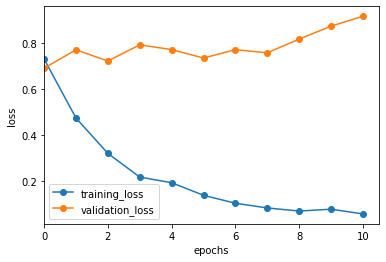

/home/ubuntu/Dataset/model/my_model09_16_31_31
['/home/ubuntu/Dataset/model/my_model09_16_31_31/Epoch_001_Val_0.692.hdf5']
/home/ubuntu/Dataset/model/my_model09_16_31_31/Epoch_001_Val_0.692.hdf5


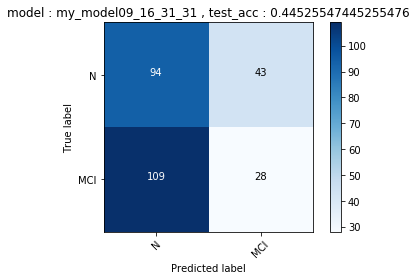

In [126]:
one_shot(e_num=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_231 (Conv2D)          (None, 32, 32, 256)       145408    
_________________________________________________________________
batch_normalization_247 (Bat (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_190 (Activation)  (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_232 (Conv2D)          (None, 32, 32, 256)       590080    
_________________________________________________________________
batch_normalization_248 (Bat (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_191 (Activation)  (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 16, 16, 256)       590080    
__________

Epoch 6/100
496/521 [===========================>..] - ETA: 0s - loss: 0.1098
Epoch 00006: val_loss did not improve from 0.66639
521/521 [==============================] - 1s 2ms/step - loss: 0.1158 - val_loss: 0.8107
Epoch 7/100
496/521 [===========================>..] - ETA: 0s - loss: 0.0918
Epoch 00007: val_loss did not improve from 0.66639
521/521 [==============================] - 1s 2ms/step - loss: 0.0958 - val_loss: 0.8659
Epoch 8/100
480/521 [==========================>...] - ETA: 0s - loss: 0.0744
Epoch 00008: val_loss did not improve from 0.66639
521/521 [==============================] - 1s 2ms/step - loss: 0.0744 - val_loss: 0.8617
Epoch 9/100
496/521 [===========================>..] - ETA: 0s - loss: 0.0826
Epoch 00009: val_loss did not improve from 0.66639
521/521 [==============================] - 1s 2ms/step - loss: 0.0813 - val_loss: 0.8612
Epoch 10/100
496/521 [===========================>..] - ETA: 0s - loss: 0.0750
Epoch 00010: val_loss did not improve from 0.6663

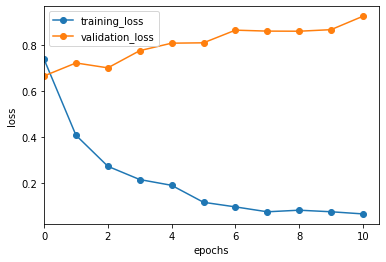

/home/ubuntu/Dataset/model/my_model09_16_33_46
['/home/ubuntu/Dataset/model/my_model09_16_33_46/Epoch_001_Val_0.666.hdf5']
/home/ubuntu/Dataset/model/my_model09_16_33_46/Epoch_001_Val_0.666.hdf5


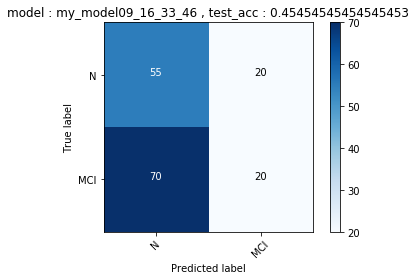

In [127]:
one_shot(e_num=4)

In [98]:
X_train[:,:,[0,1]].shape

(869, 16, 2, 63)